In [1]:
import os
import pickle
DATA_PATH = '../data/single_channel_nonlinear_mixing_tri_circ.pickle'
with open(DATA_PATH, 'rb') as outfile:
    data = pickle.load(outfile, encoding='latin1')

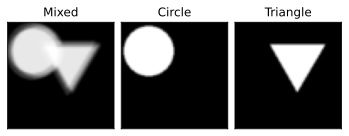

In [2]:
%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(6, 6))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(1, 3),
                 axes_pad=0.1,
                 )

idx = 0
sample, circle, triangle = data[idx]

labels = ['Mixed', 'Circle', 'Triangle']
for ax, im, label in zip(grid, [sample, circle, triangle], labels):
    ax.set_title(label)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(im, cmap='gray')

plt.show()

In [7]:
from omegaconf import OmegaConf

import sys
sys.path.append('..')
from experiments.triangles_circles import Experiment

# load model
EXPR_PATH = '../outputs/2024-03-11/12-15-12/tri_and_circ_bss/lightning_logs/version_0/checkpoints/last.ckpt'
CONFIG_PATH = '../outputs/2024-03-11/12-15-12/.hydra/config.yaml'

config = OmegaConf.load(CONFIG_PATH)
experiment = Experiment.load_from_checkpoint(checkpoint_path=EXPR_PATH, config=config.experiment_config)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = experiment.model
model.to(device)
model.eval()

ConvolutionalAutoencoder(
  (encoders): ModuleList(
    (0-2): 3 x ConvolutionalEncoder(
      (encoder): Sequential(
        (0): EncoderBlock(
          (block): Sequential(
            (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
            (1): ReLU(inplace=True)
            (2): BatchNorm2d(8, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
            (3): Conv2d(8, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
            (4): ReLU(inplace=True)
            (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
            (6): BatchNorm2d(8, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
          )
        )
        (1): EncoderBlock(
          (block): Sequential(
            (0): Conv2d(8, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
            (1): ReLU(inplace=True)
            (2): BatchNorm2d(16, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
           

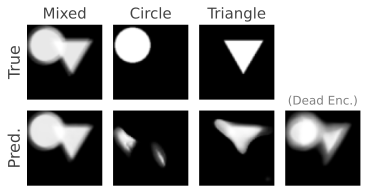

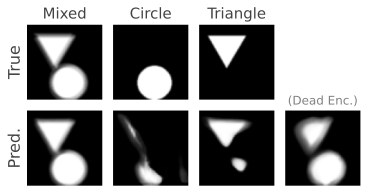

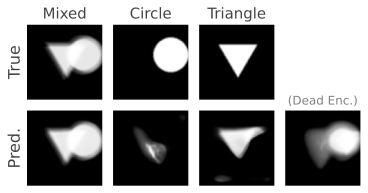

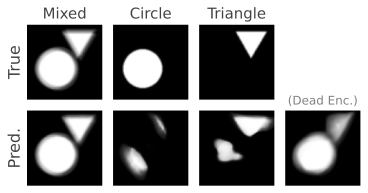

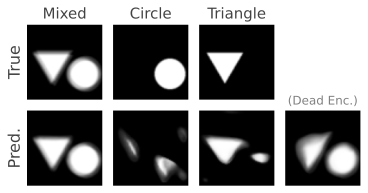

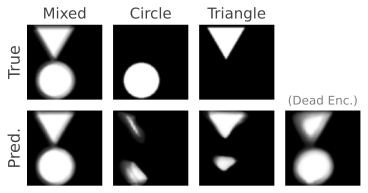

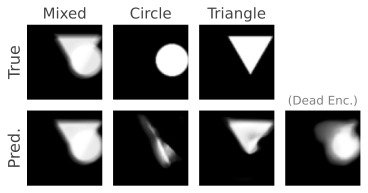

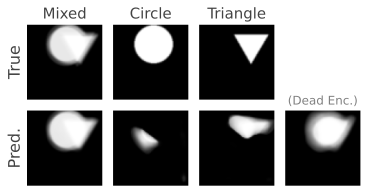

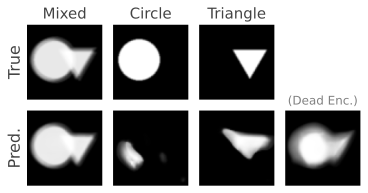

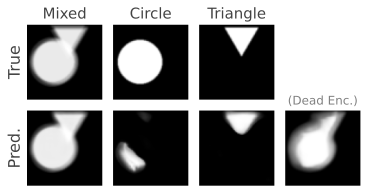

In [9]:
import torch
import matplotlib
import numpy as np

line_width = 0
matplotlib.rcParams['axes.linewidth'] = line_width
matplotlib.rcParams['ytick.major.width'] = line_width
matplotlib.rcParams['xtick.major.width'] = line_width
default_c = '#434343'
matplotlib.rcParams.update({'axes.titlesize':15,
                            'axes.labelsize': 16,
                            'text.color' : f'{default_c}',
                            'axes.labelcolor' : f'{default_c}'})

def min_max(x):
    return (x - np.min(x))/(np.max(x) - np.min(x))

for idx in range(10):
    sample, circle, triangle = data[idx]
    sample, circle, triangle = min_max(sample), min_max(circle), min_max(triangle)

    x = torch.tensor(sample, dtype=torch.float32).permute(2, 0, 1).unsqueeze_(0).to(device)
    pred, _ = model(x)
    pred = torch.sigmoid(pred).squeeze().unsqueeze(-1).detach().cpu().numpy()

    with torch.no_grad():
        z = model.encode(x)

        z_a = [z[0], torch.zeros_like(z[1]), torch.zeros_like(z[0])]
        z_b = [torch.zeros_like(z[0]), z[1], torch.zeros_like(z[0])]
        z_c = [torch.zeros_like(z[0]), torch.zeros_like(z[0]), z[2]]
        
        y_a = model.decode(z_a)
        y_b = model.decode(z_b)
        y_c = model.decode(z_c)
        
    x_pred_a = torch.sigmoid(y_a).squeeze().unsqueeze(-1).detach().cpu().numpy()
    x_pred_b = torch.sigmoid(y_b).squeeze().unsqueeze(-1).detach().cpu().numpy()
    x_pred_c = torch.sigmoid(y_c).squeeze().unsqueeze(-1).detach().cpu().numpy()

    %config InlineBackend.figure_formats = ['svg']
    import matplotlib.pyplot as plt
    %matplotlib inline
    from mpl_toolkits.axes_grid1 import ImageGrid
    fig = plt.figure(figsize=(6, 6))
    grid = ImageGrid(fig, 111,
                    nrows_ncols=(2, 4),
                    axes_pad=0.15,
                    )

    labels = ['Mixed', 'Circle', 'Triangle']
    images = [sample, circle, triangle, None, pred, x_pred_c, x_pred_a, x_pred_b] # order is switched for comparison reasons
    y_labels = ['True', 'Pred.']
    for i, (ax, im) in enumerate(zip(grid, images)):
        if i != 3:
            if i < len(labels):
                ax.set_title(labels[i])
            if i % 4 == 0:
                ax.set_ylabel(y_labels[(i)//4])
            if i+1 == len(images):
                ax.set_title('(Dead Enc.)', color='gray', fontsize=12)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(im, cmap='gray')

    plt.show()